In [10]:
import scipy as sp
import numpy as np
import pandas as pd
import anndata
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
import time as time
import warnings
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

def get(Aa,QUERY):
    from sklearn.preprocessing import StandardScaler, Normalizer
    Xs = []
    adata = Aa
    for i in range(A.index.size):
        term = A.index[i]
        ledge = A.iloc[i,-1].split(';')
        cl = np.array(list(adata.obs['PatientID']))
        X1 = adata[:,ledge].X.A[cl!=QUERY]
        X2 = adata[:,ledge].X.A[cl==QUERY]
        std=StandardScaler()
        X1 = std.fit_transform(X1)
        X2 = std.transform(X2)
        X = pd.DataFrame(data=np.vstack((X1,X2)),index=np.append(adata.obs_names[cl!=QUERY],adata.obs_names[cl==QUERY])).T[adata.obs_names].T.values.mean(1)
        Xs.append(X)
    Xs = np.vstack(Xs).T    
    return Xs

In [6]:
adata = anndata.read_h5ad('vap_study.h5ad')

In [7]:
adata.obs['PatientID'] = ([x.split('_')[1] for x in adata.obs['Identity']])
adata = adata[adata.obs['Time']=='Early'].copy()

In [17]:
PATIENTS=np.unique(adata.obs['PatientID'])
V=[]
for INCLUDE in PATIENTS:
    print(INCLUDE)
    adata2 = adata[adata.obs['PatientID']!=INCLUDE].copy()
    X = adata2.X.A
    labels = np.array(list(adata2.obs['VAP']))   
    clf = RandomForestClassifier(
        n_estimators=1000, max_depth=None, random_state=0, class_weight='balanced',
    )
    clf.fit(X,labels)    
    V.append(clf.feature_importances_)
V=np.vstack(V)
vals=V.mean(0)

C = pd.DataFrame(data = list(adata.var_names))
C['1'] = vals
C = C.sort_values('1',ascending=False)
C=C[C['1']>0.0]

import gseapy as gp
pre_res = gp.prerank(rnk=C, gene_sets='Reactome_2016',
                     processes=112,
                     permutation_num=100, # reduce number to speed up testing
                     outdir='prerank_report_kegg', format='png', seed=6)

A=pre_res.res2d[pre_res.res2d['fdr']<0.25]
A.shape

1001
1002
1047
1072
1115
1154
1158
1161
1271
1357


(393, 8)

In [18]:
PATIENTS,c=np.unique(adata.obs['PatientID'],return_counts=True)

In [19]:
XXs={}
for Q in PATIENTS:
    print(Q)
    X = get(adata,Q)
    XXs[Q] = X#sub.adata.obsm['X_pca']

1001
1002
1047
1072
1115
1154
1158
1161
1271
1357


In [20]:
PATIENTS,c=np.unique(adata.obs['PatientID'],return_counts=True)
REAL_dict = dict(zip(PATIENTS,[adata.obs['VAP'][adata.obs['PatientID']==x][0] for x in PATIENTS]))

In [24]:
labels=np.array(list(adata.obs['VAP']))
pid=np.array(list(adata.obs['PatientID']))

In [33]:
ts=[]
for p in PATIENTS:
    adata.obsm['X']=XXs[p]
    no = adata[labels=='No'].X.mean(0).A.flatten()
    yes = adata[labels=='Yes'].X.mean(0).A.flatten()

    ps=[]
    for pp in np.unique(pid):
        ps.append(adata.obsm['X'][pid==pp].mean(0).flatten())
    ps = np.array(ps)
    vap = [REAL_dict[a] for a in PATIENTS]
    t = np.array([roc_auc_score(vap,ps[:,i]) for i in range(ps.shape[1])])
    ts.append(t)
ts=np.vstack(ts).mean(0)
ts1=ts

In [ ]:
ts=[]
for p in PATIENTS:
    print(p)
    X=XXs[p]
    
    clf = RandomForestClassifier(
        n_estimators=1000, max_depth=None, random_state=0, class_weight='balanced',
    )
    clf.fit(X,labels)    
    ts.append(clf.feature_importances_)    
ts=np.vstack(ts).mean(0)
ts2=ts

1001
1002
1047
1072
1115
1154
1158
1161
1271
1357


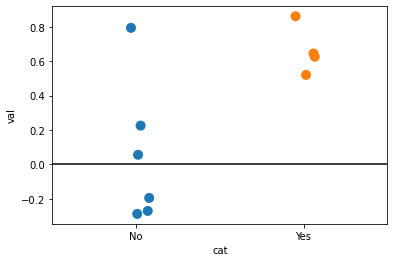

In [35]:
IX=np.argsort(-ts1*ts2)[:30]
Yreals=[]
Ypreds=[]
Yess=[]
for HELD_OUT in PATIENTS:#['1161']:
    Xs=XXs[HELD_OUT]
    Xtrain=Xs[pid!=HELD_OUT][:,IX]
    Xtest=Xs[pid==HELD_OUT][:,IX]    

    Ytrain = labels[pid!=HELD_OUT]
    Ytest = labels[pid==HELD_OUT]
    yes = Xtrain[Ytrain=='Yes'].mean(0)
    no = Xtrain[Ytrain=='No'].mean(0)
    z = Xtest.mean(0)

    sc1 = np.corrcoef(yes,z)[0,1]
    sc2 = np.corrcoef(no,z)[0,1]

    yes = Xtrain[Ytrain=='Yes'].mean(0)[None,:]
    no = Xtrain[Ytrain=='No'].mean(0)[None,:]
    
    if sc1-sc2>0.6:
        res='Yes'
    else:
        res='No'
    Ypreds.append(sc1-sc2)
    Yess.append(sc1)
    Yreals.append(REAL_dict[HELD_OUT])
    fin = 'WRONG' if  res != REAL_dict[HELD_OUT] else 'RIGHT'

import seaborn as sns
f=pd.DataFrame(data=Yess,columns=['val'])
f['cat']=Yreals
ax = sns.stripplot(data=f,x='cat',y='val',s=10)
ax.axhline(0,c='k');

In [37]:
A.iloc[IX].to_csv('gene_sets_selected_vap_study.csv')